Here we train the convolutional neural network:
We require the following folders:
- DataFiltered: contains the filtered data by class and augmented (see filter.ipynb)
- labels_upsampled.csv: contains the labels of the data

What we first do is filter the data into training, test and validation sets. 

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision.io import read_image
from torch.utils.data import DataLoader
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import shutil
import PIL
import seaborn as sns

c:\Users\Frank\anaconda3\envs\torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We filter the data into train/val/test in ratio 80|10|10.

In [2]:
labeling = pd.read_csv('./labels_upsampled.csv')
labeling

,filename,item_type,label
0,100_i110.png,100,plastic
1,100_i120.png,100,plastic
2,100_i130.png,100,plastic
3,100_i140.png,100,plastic
4,100_i150.png,100,plastic
...,...,...,...
19643,553_i190_aug115_aug_x1995.png,553,"wood,paper"
19644,892_i250_aug_x1996.png,892,"wood,paper"
19645,461_i250_aug804_aug_x1997.png,461,"wood,paper"
19646,301_i140_aug_x1998.png,301,"wood,paper"


In [3]:
unique_item_type = labeling['item_type'].unique()

In [4]:
item_shuffle = np.random.permutation(unique_item_type)
train_item_type = item_shuffle[:int(len(item_shuffle)*0.8)]
test_item_type = item_shuffle[int(len(item_shuffle)*0.8):int(len(item_shuffle)*0.9)]
val_item_type = item_shuffle[int(len(item_shuffle)*0.9):]

In [5]:
source_dir = './DataFilteredPlural/'
target_dir = './trainvaltest/'

In [6]:
#remove the target directory if it exists
if (os.path.exists(target_dir)):
    shutil.rmtree(target_dir)

#make the target directory
os.mkdir(target_dir)

In [7]:
#copy files into train/val/test based on split
if (not os.path.exists(target_dir + "train") and not os.path.exists(target_dir + "val") and not os.path.exists(target_dir + "test")):
    os.mkdir(target_dir + "train")
    os.mkdir(target_dir + "val")
    os.mkdir(target_dir + "test")

for item in train_item_type:
    list_item = labeling[labeling['item_type'] == item]
    for index, row in list_item.iterrows():
        #print(source_dir + row['filename'])
        shutil.copy(source_dir + row['filename'], target_dir + "train/" + row['filename'])

for item in val_item_type:
    list_item = labeling[labeling['item_type'] == item]
    for index, row in list_item.iterrows():
        #print(source_dir + row['filename'])
        shutil.copy(source_dir + row['filename'], target_dir + "val/" + row['filename'])

for item in test_item_type:
    list_item = labeling[labeling['item_type'] == item]
    for index, row in list_item.iterrows():
        #print(source_dir + row['filename'])
        shutil.copy(source_dir + row['filename'], target_dir + "test/" + row['filename'])

        

Training via Convolutional Neural Network:
But first we need to load the data into dataloaders

In [8]:
#frequency of each class in train/val/test
train_freq = {"metal": 0, "plastic": 0, "wood,paper": 0}
val_freq = {"metal": 0, "plastic": 0, "wood,paper": 0}
test_freq = {"metal": 0, "plastic": 0, "wood,paper": 0}

for file in os.listdir(target_dir + "train"):
    material_type = labeling[labeling['filename'] == file]['label'].values[0]
    train_freq[material_type] += 1
for file in os.listdir(target_dir + "val"):
    material_type = labeling[labeling['filename'] == file]['label'].values[0]
    val_freq[material_type] += 1
for file in os.listdir(target_dir + "test"):
    material_type = labeling[labeling['filename'] == file]['label'].values[0]
    test_freq[material_type] += 1


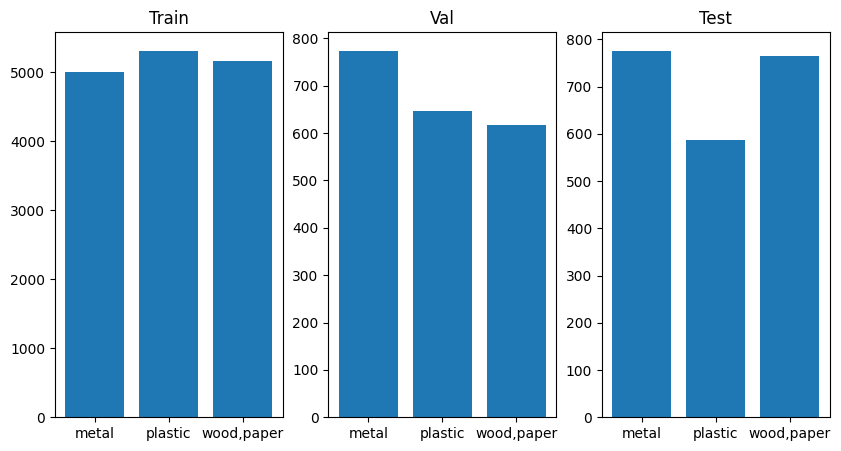

In [9]:
#plot frequency of each class in train/val/test
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.bar(train_freq.keys(), train_freq.values())
plt.title("Train")
plt.subplot(1, 3, 2)
plt.bar(val_freq.keys(), val_freq.values())
plt.title("Val")
plt.subplot(1, 3, 3)
plt.bar(test_freq.keys(), test_freq.values())
plt.title("Test")
plt.show()

In [10]:
#calculate the factor to balance the dataset
ratio = 1/3
metal_factor = 1 / (train_freq["metal"]) * len(os.listdir(target_dir + "train")) * ratio
plastic_factor = 1 / (train_freq["plastic"]) * len(os.listdir(target_dir + "train")) * ratio
wood_paper_factor = 1 / (train_freq["wood,paper"]) * len(os.listdir(target_dir + "train")) * ratio
print("metal_factor: ", metal_factor)
print("plastic_factor: ", plastic_factor)
print("wood_paper_factor: ", wood_paper_factor)

metal_factor:  1.0323462718420702
plastic_factor:  0.9709572199222181
wood_paper_factor:  0.9985807367266628


In [11]:
#custom dataset class
class Top4Dataset(Dataset):
    def __init__(self, csv_file, root_dir, label, transform=None):
        self.root_dir = root_dir
        self.annotations = pd.read_csv(csv_file)
        self.transform = transform
        self.image_names = os.listdir(root_dir)
        self.label = label
    def __len__(self):
        return len(self.image_names)
    
    def __items_class__(self):
        return self.label
    def __getitem__(self, index):
        img_name = self.image_names[index]
        img_path = os.path.join(self.root_dir, img_name)
        image = read_image(img_path)
        if self.transform:
            image = self.transform(image)
        image = image.float()
        material_name = self.annotations[self.annotations["filename"] == img_name]["label"].values[0]
        y_label = [0.0, 0.0, 0.0]
        y_label[self.label[material_name]] = 1.0
        y_label = torch.tensor(y_label)
        path = img_name
        return (image, y_label, path)

In [12]:
material_label = {"metal": 0, "plastic": 1, "wood,paper": 2}

In [13]:
#data transforms
data_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((144,144)),
    transforms.ToTensor(),
])

In [14]:
csv_file_label = "./labels_upsampled.csv"

In [15]:
Top4Dataset_train = Top4Dataset(csv_file=csv_file_label, root_dir=target_dir + "train/", label=material_label, transform=data_transforms)
Top4Dataset_val = Top4Dataset(csv_file=csv_file_label, root_dir=target_dir + "val/", label=material_label, transform=data_transforms)
Top4Dataset_test = Top4Dataset(csv_file=csv_file_label, root_dir=target_dir + "test/", label=material_label, transform=data_transforms)

print(f"length of train dataset: {len(Top4Dataset_train)}")
print(f"length of val dataset: {len(Top4Dataset_val)}")
print(f"length of test dataset: {len(Top4Dataset_test)}")

length of train dataset: 15479
length of val dataset: 2038
length of test dataset: 2127


In [16]:
DataLoader_train = DataLoader(dataset=Top4Dataset_train, batch_size=8, shuffle=True)
DataLoader_val = DataLoader(dataset=Top4Dataset_val, batch_size=8, shuffle=True)
DataLoader_test = DataLoader(dataset=Top4Dataset_test, batch_size=8, shuffle=True)

In [17]:
label_list = ['metal', 'plastic', 'wood,paper']
DataLoader_train.dataset.__items_class__()

{'metal': 0, 'plastic': 1, 'wood,paper': 2}

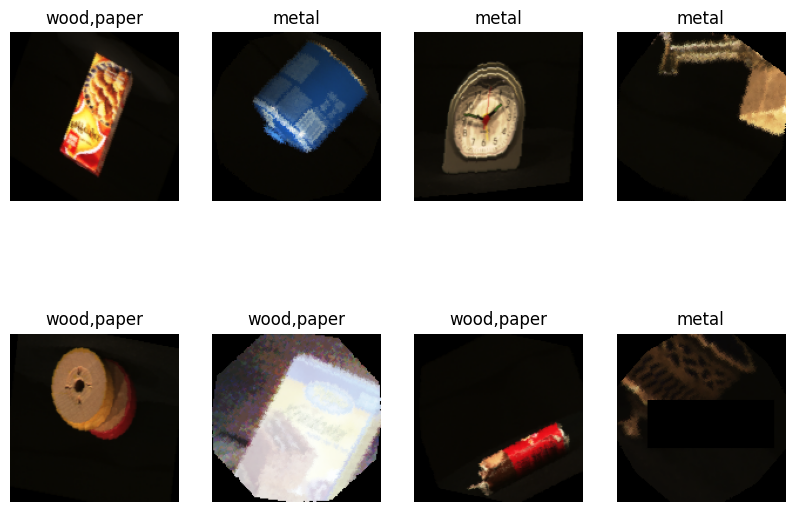

In [18]:
#show images
data = next(iter(DataLoader_train))
images, labels, path = data
plt.figure(figsize=(10, 15))
for i in range(8):
    plt.subplot(4, 4, i+1)
    plt.imshow(images[i].permute(1, 2, 0))
    plt.title(label_list[labels[i].argmax()])
    plt.axis("off")

In [19]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class ConvNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_relu_stack = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=2),
            nn.LeakyReLU(),
            nn.AvgPool2d(kernel_size=3, stride=3),
            nn.Conv2d(32, 32, kernel_size=3, padding=2),
            nn.LeakyReLU(),
            nn.AvgPool2d(kernel_size=3, stride=3),
        )
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(8192, 3),
        )

    def forward(self, x):
        logits = nn.functional.normalize(x)
        logits = self.conv_relu_stack(x)
        logits = self.flatten(logits)
        logits = nn.functional.dropout(logits, p=0.3)
        logits = self.linear_relu_stack(logits)
        return logits

model = ConvNeuralNetwork().to(device)
print(model)

Using cuda device
ConvNeuralNetwork(
  (conv_relu_stack): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): LeakyReLU(negative_slope=0.01)
    (2): AvgPool2d(kernel_size=3, stride=3, padding=0)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (4): LeakyReLU(negative_slope=0.01)
    (5): AvgPool2d(kernel_size=3, stride=3, padding=0)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=8192, out_features=3, bias=True)
  )
)


In [20]:
def train(dataloader, model, loss_fn, optimizer):
    model.train()
    size = len(dataloader.dataset)
    loss_result = 0
    for batch, (X, y, path) in enumerate(dataloader):
        # add noise to the image
        # Compute prediction error
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_result += loss.item()
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return loss_result/len(dataloader)

In [21]:
class EarlyStopper():
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf
        self.losshistory = []
        self.trainlosshistory = []

    def early_stop(self, validation_loss, train_loss, nnmodel):
        self.losshistory.append(validation_loss)
        self.trainlosshistory.append(train_loss)
        if validation_loss < self.min_validation_loss:
            torch.save(model.state_dict(), "model.pt")
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss >= (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [22]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for (X, y, z) in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss

In [23]:
weight = [metal_factor, plastic_factor, wood_paper_factor]
DataLoader_train.dataset.label

{'metal': 0, 'plastic': 1, 'wood,paper': 2}

In [24]:
#model parameters
learning_rate = 1e-3
epochs = 100
loss_fn = nn.CrossEntropyLoss(weight=torch.tensor(weight).to(device))
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-3)

In [25]:
#train model
early_stopping = EarlyStopper( patience=2, min_delta=0.0001)
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train(DataLoader_train, model, loss_fn, optimizer)
    test_loss = test(DataLoader_test, model, loss_fn)
    print(f"Train Loss: {train_loss}")
    early_stopping.early_stop(test_loss, train_loss, model)
    #if early_stopping.early_stop(test_loss, train_loss, model):
        #print("Early stopping")
        #break
print("Done!")

Epoch 1
-------------------------------
loss: 1.073235  [    0/15479]
loss: 1.088070  [  800/15479]
loss: 1.100756  [ 1600/15479]
loss: 1.088989  [ 2400/15479]
loss: 1.089020  [ 3200/15479]
loss: 1.103316  [ 4000/15479]
loss: 1.111298  [ 4800/15479]
loss: 1.062411  [ 5600/15479]
loss: 1.065974  [ 6400/15479]
loss: 1.123634  [ 7200/15479]
loss: 1.113512  [ 8000/15479]
loss: 1.092917  [ 8800/15479]
loss: 1.170623  [ 9600/15479]
loss: 1.100000  [10400/15479]
loss: 1.088937  [11200/15479]
loss: 1.050996  [12000/15479]
loss: 1.059885  [12800/15479]
loss: 1.112205  [13600/15479]
loss: 0.984540  [14400/15479]
loss: 1.129738  [15200/15479]
Test Error: 
 Accuracy: 43.2%, Avg loss: 1.065367 

Train Loss: 1.0853750969088354
Epoch 2
-------------------------------
loss: 0.984767  [    0/15479]
loss: 1.156212  [  800/15479]
loss: 1.055269  [ 1600/15479]
loss: 1.040510  [ 2400/15479]
loss: 1.147340  [ 3200/15479]
loss: 1.109071  [ 4000/15479]
loss: 1.082601  [ 4800/15479]
loss: 1.081009  [ 5600/1547

In [ ]:
plt.plot(early_stopping.losshistory, label='validation loss')
plt.plot(early_stopping.trainlosshistory, label='train loss')
plt.legend()

In [ ]:
#load best model (minimum test loss)
model.load_state_dict(torch.load("model.pt"))

In [ ]:
def predict_image(img, model):
    xb = img
    xb = transforms.Resize((144,144))(xb)
    xb = transforms.ToTensor()(xb)
    xb = xb.unsqueeze(0)
    xb = xb.to(device)
    xb = xb.float()
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

In [ ]:
material_label

In [ ]:
def confusionMatrix(model, path, material_label):
    confusion_matrix = torch.zeros(3, 3)
    with torch.no_grad():
        for file in os.listdir(path):
            img_path = file
            img = PIL.Image.open(path + img_path)
            label = labeling[labeling["filename"] == img_path]["label"].values[0]
            nr_label = material_label.get(label)
            pred = predict_image(img, model)
            confusion_matrix[nr_label, pred] += 1
    return confusion_matrix

In [ ]:
test_path = "./trainvaltest/test/"
val_path = "./trainvaltest/val/"
train_path = "./trainvaltest/train/"
test_conf_mat = confusionMatrix(model, test_path, DataLoader_test.dataset.label)
val_conf_mat = confusionMatrix(model, val_path, DataLoader_val.dataset.label)
train_conf_mat = confusionMatrix(model, train_path, DataLoader_train.dataset.label)

In [ ]:
#plot confusion matrix
plt.figure(figsize=(30,10))
plt.subplot(1,3,1)
plt.title("Confusion Matrix - Validation Data")
sns.heatmap(val_conf_mat, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.subplot(1,3,2)
plt.title("Confusion Matrix - Test Data")
sns.heatmap(test_conf_mat, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.subplot(1,3,3)
plt.title("Confusion Matrix - Train Data")
sns.heatmap(train_conf_mat, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')

